In [36]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

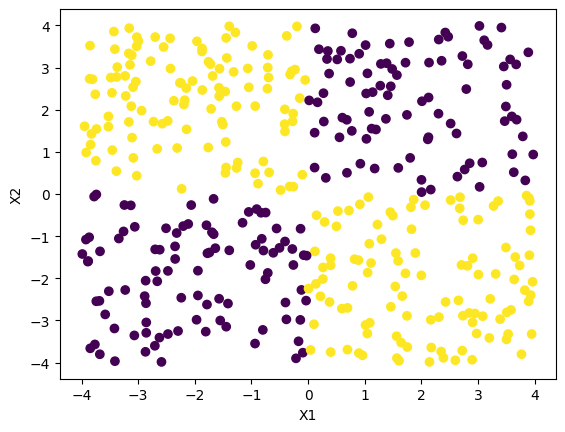

In [37]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.uniform(low=-4, high=4, size=(400,2))
y = np.bitwise_xor(np.sign(x[:,0]).astype(int),np.sign(x[:,1]).astype(int))
y[y==-2]=1
plt.scatter(x[:,0],x[:,1],c=y)
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()


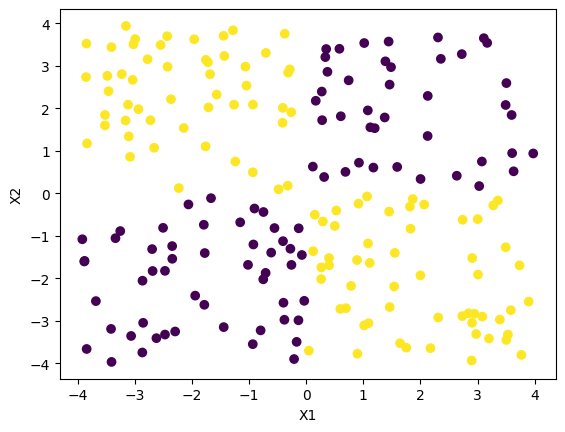

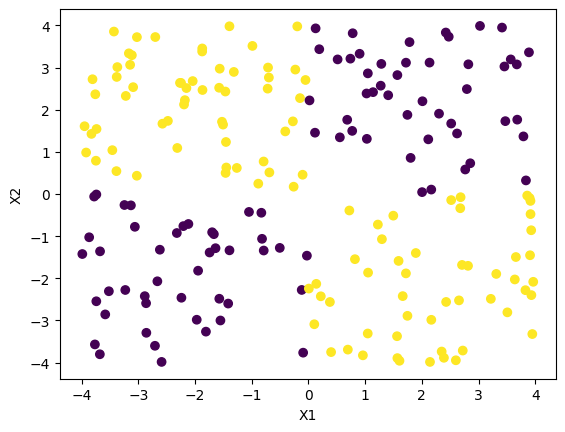

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

plt.scatter(x_test[:,0],x_test[:,1],c=y_test)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


In [39]:

def train_model(model,X_train,Y_train,X_test,Y_test,title):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel()]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  #y_pred_sig=torch.sigmoid(y_pred)
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  plt.show()


0 0.7794914841651917
100 0.3435633182525635
200 0.13436008989810944
300 0.07045090198516846
400 0.0427892729640007
500 0.027774589136242867
600 0.019631734117865562
700 0.014636478386819363
800 0.01142109651118517
900 0.009226963855326176
1000 0.007642033509910107
1100 0.006451532244682312
1200 0.00553202023729682
1300 0.0048069399781525135
1400 0.004222781863063574
1500 0.003746528411284089
1600 0.0033538402058184147
1700 0.0030196369625627995
1800 0.0027371826581656933
1900 0.002495719352737069
2000 0.0022861629258841276
2100 0.002103567821905017
2200 0.001942796865478158
2300 0.0017996609676629305
2400 0.0016725304303690791
2500 0.0015585171058773994
2600 0.0014547556638717651
2700 0.0013609075685963035
2800 0.0012757682707160711
2900 0.0011985809542238712
3000 0.001125933020375669
3100 0.001060302136465907
3200 0.0009989311220124364
3300 0.0009429377969354391
3400 0.000890315743163228
3500 0.0008418216020800173
3600 0.0007966745179146528
3700 0.0007543977117165923
3800 0.0007147261

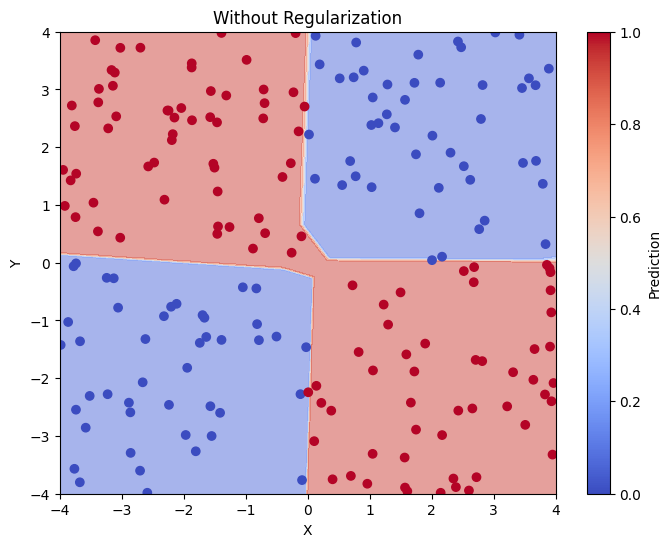

In [40]:
# model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(), nn.Linear(4, 2),nn.Linear(2, 4), nn.ReLU(), nn.Linear(2, 1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Liner(4, 2),nn.Tanh(),nn.Linear(2,1))
model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
#model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(),nn.Linear(2,1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Linear(4, 2),nn.Tanh(),nn.Linear(2,1))
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model(model,X_train,Y_train,X_test,Y_test,"Without Regularization")

In [41]:
def compute_l1_loss(w):
      return torch.abs(w).sum()

def compute_l2_loss(w):
      return torch.square(w).sum()

In [44]:

def train_model_Reg(model,X_train,Y_train,X_test,Y_test,isL1,title,l1_weight,l2_weight):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      #l1_weight = 0.3
      #l2_weight = 0.7

      # Compute L1 and L2 loss component
      parameters = []
      for parameter in model.parameters():
          parameters.append(parameter.view(-1))

      penalty_loss=0

      if isL1:
          penalty_loss = l1_weight * compute_l1_loss(torch.cat(parameters))
      else:
          penalty_loss = l2_weight * compute_l2_loss(torch.cat(parameters))

      # Add L1 and L2 loss components
      loss+=penalty_loss
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel()]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  #y_pred_sig=torch.sigmoid(y_pred)
  print(y_pred[0])
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  #plt.grid(True)
  plt.show()


0 0.7285230159759521
100 0.42637211084365845
200 0.3712010979652405
300 0.3572542071342468
400 0.35344749689102173
500 0.35189083218574524
600 0.3508400022983551
700 0.3502101004123688
800 0.3497636020183563
900 0.3493898808956146
1000 0.34911003708839417
1100 0.34873974323272705
1200 0.3484818935394287
1300 0.3482276201248169
1400 0.3478085696697235
1500 0.3475068211555481
1600 0.3472308814525604
1700 0.3468782901763916
1800 0.3464135229587555
1900 0.34581077098846436
2000 0.34569674730300903
2100 0.3451162874698639
2200 0.05614345520734787
2300 0.04696766287088394
2400 0.04446806386113167
2500 0.043384622782468796
2600 0.04278663918375969
2700 0.04241134598851204
2800 0.042152635753154755
2900 0.041973333805799484
3000 0.04182712361216545
3100 0.04171943664550781
3200 0.04163658991456032
3300 0.041568368673324585
3400 0.04150545969605446
3500 0.04145757108926773
3600 0.041415877640247345
3700 0.04137923941016197
3800 0.041352853178977966
3900 0.04132136330008507
4000 0.04129898175597

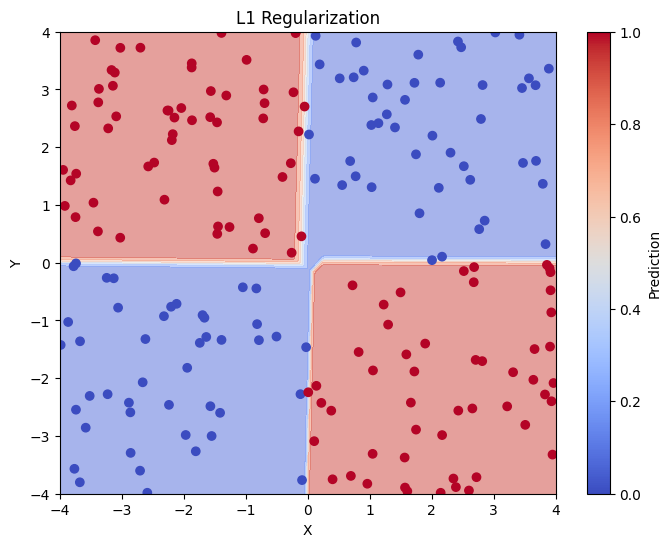

In [49]:
model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
#model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(),nn.Linear(2,1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Linear(4, 2),nn.Tanh(),nn.Linear(2,1))
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_Reg(model,X_train,Y_train,X_test,Y_test,True,"L1 Regularization",l1_weight=0.001,l2_weight=0.7)

0 0.8343819379806519
100 0.36666619777679443
200 0.3172376751899719
300 0.30899056792259216
400 0.30691879987716675
500 0.30641597509384155
600 0.3062402009963989
700 0.3062235414981842
800 0.30623120069503784
900 0.3062235713005066
1000 0.30621761083602905
1100 0.3062019348144531
1200 0.30622056126594543
1300 0.3062024414539337
1400 0.30620378255844116
1500 0.30624616146087646
1600 0.3062053322792053
1700 0.3062211871147156
1800 0.3062310218811035
1900 0.30625736713409424
2000 0.3062174916267395
2100 0.30620378255844116
2200 0.30620744824409485
2300 0.3062080144882202
2400 0.3062010407447815
2500 0.30622598528862
2600 0.3061944842338562
2700 0.30620312690734863
2800 0.306216299533844
2900 0.3061971068382263
3000 0.30619752407073975
3100 0.30621328949928284
3200 0.3062096834182739
3300 0.30619335174560547
3400 0.30621135234832764
3500 0.3061996102333069
3600 0.30622994899749756
3700 0.30619311332702637
3800 0.3062448799610138
3900 0.30619633197784424
4000 0.30622345209121704
4100 0.306

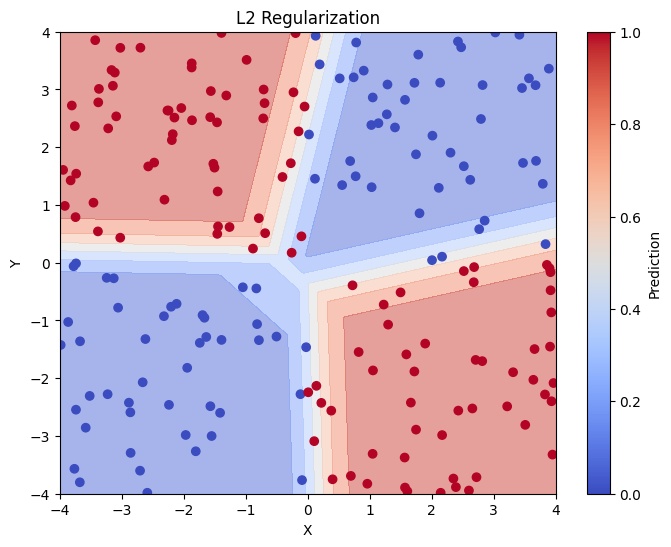

In [46]:
model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
#model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(),nn.Linear(2,1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Linear(4, 2),nn.Tanh(),nn.Linear(2,1))
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_Reg(model,X_train,Y_train,X_test,Y_test,False,"L2 Regularization",l1_weight=0.001,l2_weight=0.01)

In [47]:

def train_model_logistic(model,X_train,Y_train,X_test,Y_test,title):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel(),X.ravel()[:]*Y.ravel()[:]]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  #y_pred_sig=torch.sigmoid(y_pred)
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  plt.show()


0 0.2786736786365509
100 0.14877460896968842
200 0.11757415533065796
300 0.10003460198640823
400 0.08817154169082642
500 0.07940695434808731
600 0.07258165627717972
700 0.0670742318034172
800 0.06251294910907745
900 0.05865822732448578
1000 0.055347226560115814
1100 0.05246472731232643
1200 0.04992636293172836
1300 0.047669023275375366
1400 0.045644283294677734
1500 0.04381437227129936
1600 0.04214936122298241
1700 0.040625281631946564
1800 0.039222538471221924
1900 0.0379251092672348
2000 0.036719661206007004
2100 0.03559506684541702
2200 0.03454190120100975
2300 0.033552248030900955
2400 0.03261925280094147
2500 0.031737059354782104
2600 0.030900605022907257
2700 0.03010547161102295
2800 0.029347814619541168
2900 0.028624268248677254
3000 0.02793184109032154
3100 0.027267925441265106
3200 0.02663016878068447
3300 0.026016507297754288
3400 0.025425083935260773
3500 0.024854226037859917
3600 0.02430245652794838
3700 0.023768436163663864
3800 0.02325093187391758
3900 0.02274885587394237

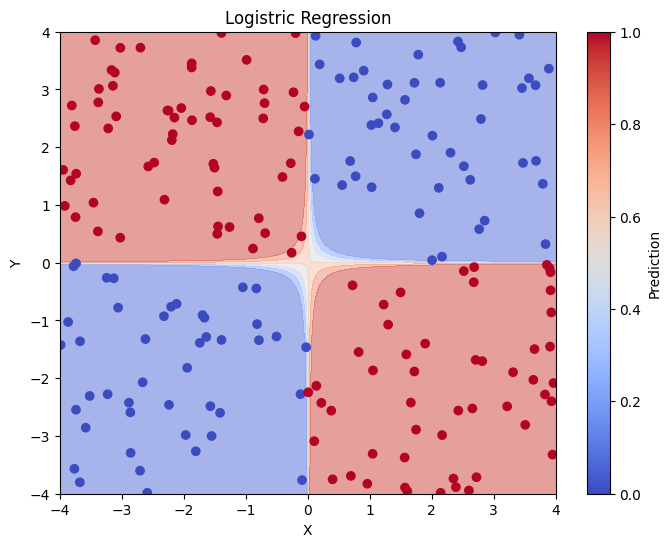

In [48]:
model = nn.Sequential(nn.Linear(3,1),nn.Sigmoid())
#model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(),nn.Linear(2,1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Linear(4, 2),nn.Tanh(),nn.Linear(2,1))
model.to(device)
column=x_train[:,0]*x_train[:,1]
x_train_ = np.insert(x_train, 2, column, axis=1)
column=x_test[:,0]*x_test[:,1]
x_test_ = np.insert(x_test, 2, column, axis=1)
X_train=torch.tensor(x_train_,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test_,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_logistic(model,X_train,Y_train,X_test,Y_test,"Logistric Regression")

Observations

1) Simple MLP without regularization

      -> We have used 2 hidden layer of size 4 and 2 respectively. Both layers
        have Relu activation function as non linearity. Output layer has one neuron and sigmoid function is applied to it.

      -> We trained over 10000 epochs with learning rate 0.01. We have got almost perfect decision boundary except 2-3 points are on the boundary line.

2) L1 Regularization

      -> Using tenserflow playground, We applied different weight coefficients for regularization. So finally ,we used 0.001 as a weight coefficient.

      -> Due to L1 regularization, weights goes down and some weights becomes completely zero. Due to that some points gives value close to zero at output layer which became 0.5 after applying sigmoid.

      -> So, In L1 regularization, we can see that decision boundary is not very sharp because some points around the boundary predicted value close to 0.5

3) L2 Regularization

      -> Using tenserflow playground, We applied different weight coefficients for regularization. So finally ,we used 0.01 as a weight coefficient.

      -> Due to L2 regularization, weights goes down and some weights becomes completely zero. Due to that some points gives value close to zero at output layer which became 0.5 after applying sigmoid

      -> So, In L2 regularization, we can see that decision boundary is not perfect as compared of L1 regularization.


4) Logistic regression

      -> In this we used x1*x2, as extra feature while training.

      -> We trained over 10000 epochs with learning rate 0.01. We have got almost perfect decision boundary except 2-3 points are on the boundary line.


      